# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt


## Device

Set device to work with (GPU or CPU)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

/tmp/ipykernel_32/3023846552.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x_train = np.array([x[0] for x in train_dataset])
/tmp/ipykernel_32/3023846552.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array([x[0] for x in train_dataset])


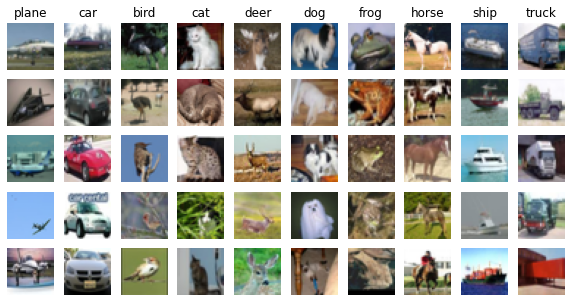

In [6]:
x_train = np.array([x[0] for x in train_dataset])
y_train = np.array([x[1] for x in train_dataset])

samples = []
for i in range(10):
  t = np.isin(y_train, [i]).flatten()
  t = [i for i,x in enumerate(t) if x]
  t = random.sample(t,5)
  t = x_train[t]
  samples.append(t)

fig = plt.figure(figsize=(16,8))
for i in range(50):
  fig.add_subplot(5,10,i+1)
  label = i%10
  num = int(i/10)
  image = samples[label][num]
  plt.imshow(image.permute(1,2,0).numpy())
  if num == 0:
    plt.title(classes[label])
  plt.axis('off')
plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [5]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class NeuralNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten()
                                        )
        self.lin1 = nn.Sequential(nn.Dropout(p=0.35),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        out = self.lin1(out)
        return out
    def get_feature_space(self,xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
        

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [12]:
net = NeuralNet(3,10).to(device)
net

NeuralNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [13]:
num_of_epochs = 15
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.03, steps_per_epoch=len(train_loader), epochs=num_of_epochs)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [14]:
from time import time
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epochs_nums = [i+1 for i in range(num_of_epochs)]
def train_epoch(net, criterion, optimizer, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.train()
    
    for i,data in enumerate(dataloader):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        p = net(x)

        loss = criterion(p, y)
        epoch_loss += float(loss)

        predictions = p.argmax(-1)
        epoch_all += len(predictions)
        epoch_true += (predictions == y).sum()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        sched.step()
    print(f'Loss: {epoch_loss / epoch_all:.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
    train_losses.append(epoch_loss/epoch_all)
    train_accs.append(float(epoch_true/epoch_all))
    

        
def eval_epoch(net, criterion, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.eval()
    for i,data in enumerate(dataloader):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        p = net(x)

        loss = criterion(p, y)
        epoch_loss += float(loss)

        predictions = p.argmax(-1)
        epoch_all += len(predictions)
        epoch_true += (predictions == y).sum()

    print(f'Loss: {epoch_loss / epoch_all:.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
    val_losses.append(epoch_loss/epoch_all)
    val_accs.append(float(epoch_true/epoch_all))


for e in range(num_of_epochs):
    
    print(f'Epoch {e+1:3} started')
    start_time = time()

    train_epoch(net, criterion, optimizer, train_loader)
    eval_epoch(net, criterion, val_loader)

    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')
    


Epoch   1 started
Loss: 6.758e-03 - Acc: 40.39%
Loss: 2.149e-02 - Acc: 48.70%
Epoch   1 finished in 41.95s
Epoch   2 started
Loss: 4.954e-03 - Acc: 56.30%
Loss: 3.948e-02 - Acc: 39.43%
Epoch   2 finished in 41.92s
Epoch   3 started
Loss: 3.655e-03 - Acc: 67.96%
Loss: 3.049e-02 - Acc: 41.57%
Epoch   3 finished in 41.99s
Epoch   4 started
Loss: 2.744e-03 - Acc: 76.32%
Loss: 2.771e-02 - Acc: 55.69%
Epoch   4 finished in 41.88s
Epoch   5 started
Loss: 2.305e-03 - Acc: 80.28%
Loss: 1.455e-02 - Acc: 69.73%
Epoch   5 finished in 41.93s
Epoch   6 started
Loss: 1.843e-03 - Acc: 84.17%
Loss: 1.706e-02 - Acc: 67.52%
Epoch   6 finished in 41.91s
Epoch   7 started
Loss: 1.504e-03 - Acc: 87.15%
Loss: 1.547e-02 - Acc: 71.89%
Epoch   7 finished in 42.03s
Epoch   8 started
Loss: 1.190e-03 - Acc: 89.79%
Loss: 1.116e-02 - Acc: 78.55%
Epoch   8 finished in 41.98s
Epoch   9 started
Loss: 8.438e-04 - Acc: 92.64%
Loss: 9.655e-03 - Acc: 82.24%
Epoch   9 finished in 41.98s
Epoch  10 started
Loss: 5.148e-04 - A

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

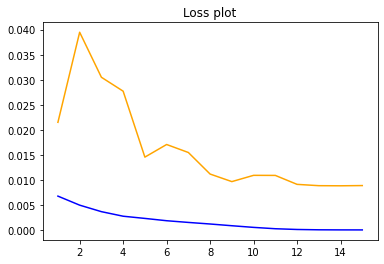

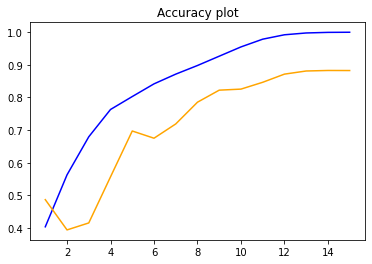

In [15]:
val_accs = [float(x) for x in val_accs]
plt.plot(epochs_nums,train_losses,'blue')
plt.plot(epochs_nums,val_losses,'orange')
plt.title('Loss plot')
plt.show()
plt.plot(epochs_nums,train_accs,'blue')
plt.plot(epochs_nums,val_accs,'orange')
plt.title('Accuracy plot')
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [19]:
wrongs = []
correct_samples = []
wrong_preds = []
correct_class = []
def test(net, criterion, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.eval()
    for i,data in enumerate(dataloader):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        p = net(x)

        loss = criterion(p, y)
        epoch_loss += float(loss)

        predictions = p.argmax(-1)
        epoch_all += len(predictions)
        epoch_true += (predictions == y).sum()
        for i in range(len(predictions)):
            if predictions[i]!=y[i]:
                wrongs.append(x[i])
                wrong_preds.append(predictions[i])
                correct_class.append(y[i])
            else:
                correct_samples.append(x[i])

    print(f'{epoch_true * 100. / epoch_all:.2f}%')

test(net,criterion,test_loader)

87.99%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

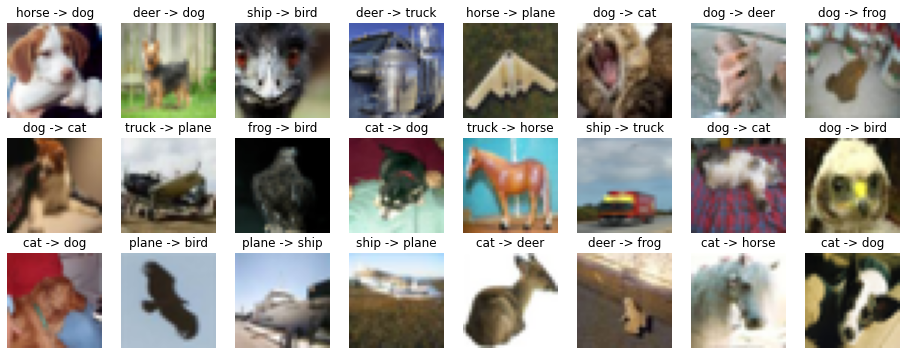

In [20]:
wrongs_np = [x.cpu() for x in wrongs]
wrong_preds_a = [int(x.cpu()) for x in wrong_preds]
correct_class_a = [int(x.cpu()) for x in correct_class]
inds = random.choices(range(len(wrongs_np)),k=24)
figg = plt.figure(figsize=(16,6))
for i in range(24):
    figg.add_subplot(3,8,i+1)
    image = wrongs_np[i]
    plt.imshow(image.permute(1,2,0).numpy())
    plt.title(classes[wrong_preds_a[i]] + ' -> ' + classes[correct_class_a[i]])
    plt.axis('off')
plt.show()
    
    


## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [21]:
feature_spaces = []
for i,data in enumerate(train_loader):
    imgs,lbls = data
    imgs = imgs.to(device)
    lbls = imgs.to(device)
    features = net.get_feature_space(imgs)
    if i == 0:
        feature_spaces = features.cpu().detach().numpy()
    else:
        feature_spaces = np.concatenate((feature_spaces,features.cpu().detach().numpy()),0)
        
for i,data in enumerate(val_loader):
    imgs,lbls = data
    imgs = imgs.to(device)
    lbls = imgs.to(device)
    features = net.get_feature_space(imgs)
    feature_spaces = np.concatenate((feature_spaces,features.cpu().detach().numpy()),0)
    
print(feature_spaces.shape)


(50000, 512)


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

(2000, 2)


Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

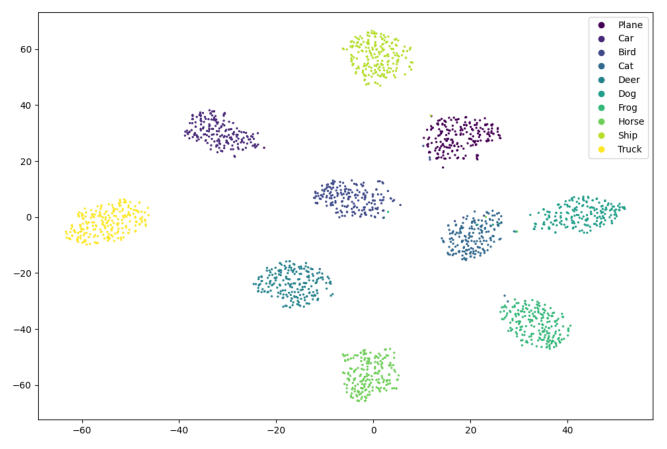

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [20]:
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
from skimage import color

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [2]:
class DSClass(CIFAR10):

    def __getitem__(self, index):
        original_image, label = super().__getitem__(index)
        gray_image = transforms.functional.rgb_to_grayscale(original_image, num_output_channels=3)
        return original_image, gray_image , label

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [3]:
train_data = DSClass('./data', transform=transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
]), train=True, download=True)
test_data = DSClass('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]))
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(train_data)))
train_indices, valid_indices = indices[split:], indices[:split]
train_loader = DataLoader(train_data, batch_size=256,
    sampler=SubsetRandomSampler(train_indices), num_workers=0)
val_loader = DataLoader(train_data, batch_size=64, 
    sampler=SubsetRandomSampler(valid_indices), num_workers=0)
test_loader = DataLoader(test_data, batch_size=64, 
    num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

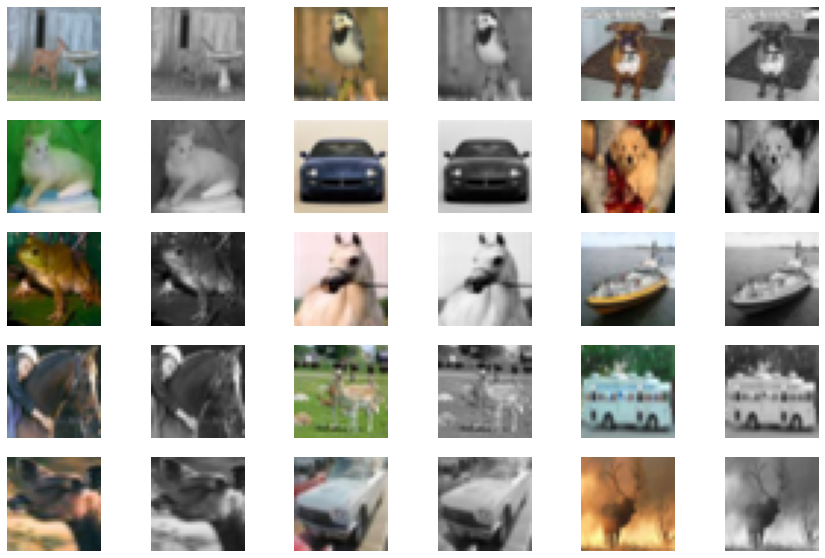

In [4]:
dataiter = iter(train_loader)
originals, grays, labels = dataiter.next()
originals = originals.numpy() 
grays = grays.numpy()

fig = plt.figure(figsize=(15, 10))
for i in range(15):
    fig.add_subplot(5, 6, 2*i+1)
    plt.imshow(np.transpose(originals[i], (1, 2, 0)))
    plt.axis('off')
    fig.add_subplot(5, 6, 2*i+2)
    plt.imshow(np.transpose(grays[i], (1, 2, 0)))
    plt.axis('off')
plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [5]:
class CNN(nn.Module):
    def __init__(self, d=128):
        super(CNN, self).__init__()
        
        self.conv_lay1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
                                                                     nn.BatchNorm2d(32),
                                                                                nn.ReLU())
        self.conv_lay2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), 
                                                                      nn.BatchNorm2d(64),
                                                                                nn.ReLU())
        self.conv_lay3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
                                                                    nn.BatchNorm2d(128),
                                                                               nn.ReLU())
        self.conv_lay4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), 
                                                                       nn.BatchNorm2d(128),
                                                                                nn.ReLU())
        self.drop = nn.Dropout(0.2)
        self.conv_lay5 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), 
                                                                       nn.BatchNorm2d(128),
                                                                                 nn.ReLU())
        self.conv_lay6 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                                                       nn.BatchNorm2d(128),
                                                                                 nn.ReLU())
        self.convt_lay1 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                                                                                 nn.BatchNorm2d(64),
                                                                                          nn.ReLU())
        self.convt_lay2 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), 
                                                                                nn.BatchNorm2d(32),
                                                                                        nn.ReLU())
        self.convt3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        

    def forward(self, input):
        x = self.conv_lay1(input)
        x = self.conv_lay2(x)
        x = self.conv_lay3(x)
        x = self.conv_lay4(x)
        x = self.drop(x)
        x = self.conv_lay5(x)
        x = self.conv_lay6(x)
        x = self.convt_lay1(x)
        x = self.convt_lay2(x)
        x = self.convt3(x)
        

        return x

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnet = CNN()
cnet = cnet.to(device)

In [16]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=1e-2)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(train_loader), epochs=25)

train_losses = []
val_losses = []

for epoch in range(25):
    train_batches = 0
    train_loss = 0
    val_loss = 0
    cnet.train()
    for originals, x, labels in train_loader:
        
        originals = originals.to(device)
        x = x.to(device)
        p = cnet(x)
        loss = F.mse_loss(p, originals)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sched.step()
        train_loss += loss.item()
        train_batches += 1

    val_batches = 0
    cnet.eval()
    for originals, x, labels in val_loader:
        x = x.cuda()
        originals = originals.cuda()
        p = cnet(x) 
        loss = F.mse_loss(p, originals) 
        val_loss += loss.item()
        val_batches += 1
                
    train_loss /= train_batches
    val_loss /= val_batches
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1:} : Train Loss: {train_loss:.3e} - Val Loss: {val_loss:.3e}')

Epoch 1 : Train Loss: 6.623e-02 - Val Loss: 2.315e-02
Epoch 2 : Train Loss: 1.952e-02 - Val Loss: 1.630e-02
Epoch 3 : Train Loss: 1.520e-02 - Val Loss: 1.622e-02
Epoch 4 : Train Loss: 1.360e-02 - Val Loss: 1.263e-02
Epoch 5 : Train Loss: 1.250e-02 - Val Loss: 1.729e-02
Epoch 6 : Train Loss: 1.181e-02 - Val Loss: 1.444e-02
Epoch 7 : Train Loss: 1.108e-02 - Val Loss: 1.282e-02
Epoch 8 : Train Loss: 1.045e-02 - Val Loss: 1.079e-02
Epoch 9 : Train Loss: 9.821e-03 - Val Loss: 8.936e-03
Epoch 10 : Train Loss: 9.355e-03 - Val Loss: 1.000e-02
Epoch 11 : Train Loss: 9.302e-03 - Val Loss: 9.069e-03
Epoch 12 : Train Loss: 9.234e-03 - Val Loss: 9.484e-03
Epoch 13 : Train Loss: 9.099e-03 - Val Loss: 8.545e-03
Epoch 14 : Train Loss: 8.822e-03 - Val Loss: 8.433e-03
Epoch 15 : Train Loss: 8.578e-03 - Val Loss: 8.005e-03
Epoch 16 : Train Loss: 8.379e-03 - Val Loss: 8.285e-03
Epoch 17 : Train Loss: 8.271e-03 - Val Loss: 8.327e-03
Epoch 18 : Train Loss: 8.167e-03 - Val Loss: 7.978e-03
Epoch 19 : Train Lo

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

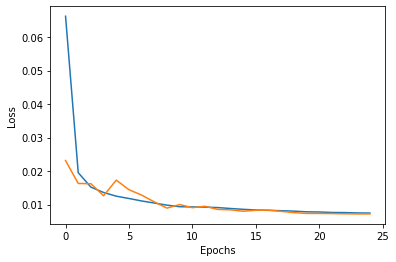

In [17]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(val_losses, label='Validation Loss')
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


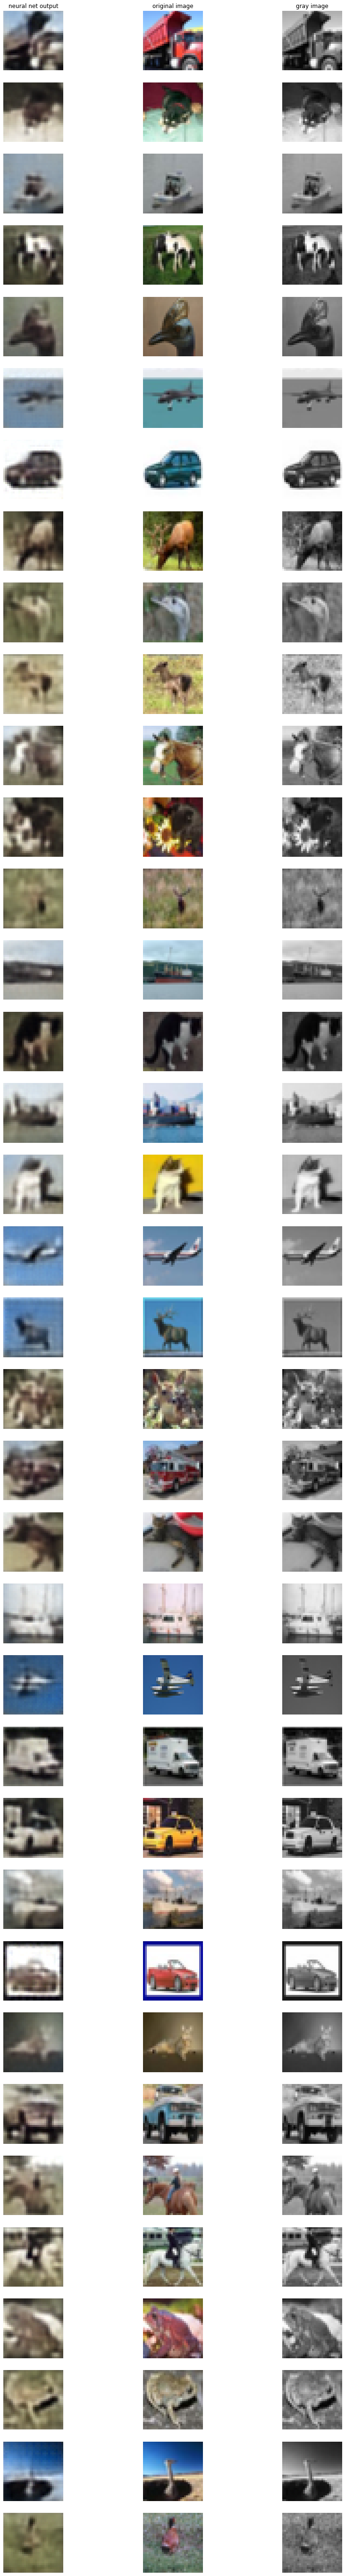

In [33]:
originals_list = []
outputs_list = []
sample_inds = np.random.choice(len(test_data), 36, replace=False)
inputs = torch.stack([test_data[i][1] for i in sample_inds])
inputs = inputs.to(device)
p = cnet(inputs).cpu()
inputs = inputs.cpu()
for i in range(36):
    colored_image = np.transpose(test_data[sample_inds[i]][0].detach().numpy().astype('float64'), (1, 2, 0))
    originals_list.append(torch.FloatTensor(np.transpose(colored_image, (2, 0, 1))))
    output_image = p[i].detach().numpy().astype('float64')
    outputs_list.append(torch.FloatTensor(output_image))
fig = plt.figure(figsize=(15, 100))
for i in range(36):
    fig.add_subplot(36, 3, 3*i+1)
    plt.imshow(np.transpose(outputs_list[i], (1, 2, 0)))
    if(i==0):
        plt.title('neural net output')
    plt.axis('off')
    fig.add_subplot(36, 3, 3*i+2)
    plt.imshow(np.transpose(originals_list[i], (1, 2, 0)))
    plt.axis('off')
    if(i==0):
        plt.title('original image')
    fig.add_subplot(36, 3, 3*i+3)
    plt.imshow(np.transpose(inputs[i], (1, 2, 0)))
    plt.axis('off')
    if(i==0):
        plt.title('gray image')

plt.show()